# 🧠 Part 1: Building CNN from Scratch
## בניית SimpleCNN ואימון ראשוני

---

### 🎯 מטרות המחברת:
1. **בניית SimpleCNN** - רשת קונבולוציונית פשוטה (2-3 שכבות)
2. **לולאת אימון** - הבנת תהליך ה-training loop ב-PyTorch
3. **Validation** - בדיקת ביצועים על Val set
4. **ויזואליזציה** - גרפים של Loss ו-Accuracy
5. **שמירת מודל** - שמירת המודל הטוב ביותר

---

### 📚 מה נלמד?
- איך לבנות CNN ב-PyTorch (מאפס!)
- מהו Forward Pass ו-Backward Pass
- איך עובד Optimizer ו-Loss Function
- איך לעקוב אחרי התקדמות האימון
- מתי לעצור אימון (overfitting vs underfitting)

## 1️⃣ ייבוא ספריות וטעינת ה-Dataset

In [1]:
# ייבוא ספריות
import os
import sys
from pathlib import Path
import json
import time

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder

# Data Science
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm.notebook import tqdm

# ייבוא config
sys.path.append(str(Path.cwd().parent / 'src'))
import config

print("✅ All libraries imported!")
print(f"🖥️  Device: {config.DEVICE}")
print(f"📦 Batch size: {config.BATCH_SIZE}")
print(f"📈 Learning rate: {config.LEARNING_RATE}")
print(f"🔢 Epochs: {config.NUM_EPOCHS}")

✅ All libraries imported!
🖥️  Device: cpu
📦 Batch size: 32
📈 Learning rate: 0.001
🔢 Epochs: 50


## 2️⃣ טעינת ה-Dataset Splits מ-Notebook 01

### 📂 מה אנחנו טוענים?
ב-notebook הקודם שמרנו:
- `train_indices` - אינדקסים של תמונות train
- `val_indices` - אינדקסים של תמונות validation  
- `test_indices` - אינדקסים של תמונות test
- `class_names` - שמות המחלקות

עכשיו נטען את אותם splits בדיוק!

In [2]:
# טעינת splits מהקובץ
splits_path = config.RESULTS_DIR / 'dataset_splits.json'

with open(splits_path, 'r') as f:
    splits_data = json.load(f)

train_indices = splits_data['train_indices']
val_indices = splits_data['val_indices']
test_indices = splits_data['test_indices']
class_names = splits_data['class_names']
num_classes = splits_data['num_classes']

print("✅ Splits loaded successfully!")
print(f"📊 Train: {len(train_indices)} images")
print(f"📊 Val: {len(val_indices)} images")
print(f"📊 Test: {len(test_indices)} images")
print(f"🏷️  Classes: {class_names}")

✅ Splits loaded successfully!
📊 Train: 1466 images
📊 Val: 314 images
📊 Test: 315 images
🏷️  Classes: ['cardboard box waste', 'crushed aluminum can', 'glass bottle waste', 'plastic bottle waste']


## 3️⃣ יצירת DataLoaders

### 🔄 Transforms - בדיוק כמו ב-Notebook 01

In [3]:
# Transforms (בדיוק כמו ב-notebook 01)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Train transforms (עם augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE + 32, config.IMAGE_SIZE + 32)),
    transforms.RandomCrop((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Val/Test transforms (ללא augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("✅ Transforms defined!")

✅ Transforms defined!


In [4]:
# יצירת Datasets
data_path = config.DATA_PATH

train_dataset_full = ImageFolder(root=str(data_path), transform=train_transforms)
train_dataset = Subset(train_dataset_full, train_indices)

val_dataset_full = ImageFolder(root=str(data_path), transform=val_test_transforms)
val_dataset = Subset(val_dataset_full, val_indices)

# יצירת DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print("✅ DataLoaders created!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

✅ DataLoaders created!
   Train batches: 46
   Val batches: 10


## 4️⃣ הגדרת SimpleCNN - הארכיטקטורה הראשונה שלנו! 🏗️

### 🧠 מבנה SimpleCNN:

```
Input: [32, 3, 224, 224]
   ↓
Conv1 (3→32) + ReLU + MaxPool → [32, 32, 112, 112]
   ↓
Conv2 (32→64) + ReLU + MaxPool → [32, 64, 56, 56]
   ↓
Flatten → [32, 200704]
   ↓
Linear (200704→512) + ReLU + Dropout → [32, 512]
   ↓
Linear (512→4) → [32, 4]
```

### 📝 הסבר על כל שכבה:
- **Conv1**: מחפש פיצ'רים בסיסיים (קצוות, צבעים)
- **Conv2**: מחפש פיצ'רים מורכבים יותר (צורות, טקסטורות)
- **Flatten**: הופך ל-vector
- **Linear1**: לומד ייצוגים מופשטים
- **Linear2**: מחליט על מחלקה

In [ ]:
class SimpleCNN(nn.Module):
    """
    SimpleCNN - רשת קונבולוציונית פשוטה עם 2 שכבות conv
    
    Architecture:
    - Conv1: 3 → 32 channels (kernel=3x3)
    - Conv2: 32 → 64 channels (kernel=3x3)
    - FC1: 200704 → 512
    - FC2: 512 → num_classes
    """
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        
        # === Convolutional Layers ===
        
        # Block 1: Conv → ReLU → MaxPool
        self.conv1 = nn.Conv2d(
            in_channels=3,      # RGB input
            out_channels=16,    # הורדנו ל-16 (היה 32)
            kernel_size=3,      # 3x3 filter
            padding=1           # padding כדי לשמור על גודל
        )
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # מקטין ×2
        
        # Block 2: Conv → ReLU → MaxPool
        self.conv2 = nn.Conv2d(
            in_channels=16,     # מקבל 16 מ-conv1
            out_channels=32,    # הורדנו ל-32 (היה 64)
            kernel_size=3,
            padding=1
        )
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # מקטין ×2
        
        # Block 3: Conv נוסף לעומק
        self.conv3 = nn.Conv2d(
            in_channels=32,
            out_channels=64,    # 64 feature maps
            kernel_size=3,
            padding=1
        )
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # מקטין ×2
        
        # === Fully Connected Layers ===
        
        # חישוב גודל אחרי conv layers:
        # Input: 224×224
        # אחרי pool1: 112×112
        # אחרי pool2: 56×56
        # אחרי pool3: 28×28
        # סך הכל: 64 × 28 × 28 = 50,176 features (הרבה פחות!)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(64 * 28 * 28, 256)  # הורדנו ל-256 (היה 512)
        self.relu4 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.6)  # הגברנו dropout (היה 0.5)
        
        self.fc2 = nn.Linear(256, 128)  # שכבת ביניים נוספת
        self.relu5 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.fc3 = nn.Linear(128, num_classes)  # 128 → 4 classes
        
    def forward(self, x):
        """
        Forward pass - מעבר קדימה דרך הרשת
        
        Args:
            x: Input tensor [batch_size, 3, 224, 224]
            
        Returns:
            Output tensor [batch_size, num_classes]
        """
        # Block 1
        x = self.conv1(x)      # [B, 3, 224, 224] → [B, 16, 224, 224]
        x = self.relu1(x)
        x = self.pool1(x)      # [B, 16, 224, 224] → [B, 16, 112, 112]
        
        # Block 2
        x = self.conv2(x)      # [B, 16, 112, 112] → [B, 32, 112, 112]
        x = self.relu2(x)
        x = self.pool2(x)      # [B, 32, 112, 112] → [B, 32, 56, 56]
        
        # Block 3
        x = self.conv3(x)      # [B, 32, 56, 56] → [B, 64, 56, 56]
        x = self.relu3(x)
        x = self.pool3(x)      # [B, 64, 56, 56] → [B, 64, 28, 28]
        
        # Flatten
        x = self.flatten(x)    # [B, 64, 28, 28] → [B, 50176]
        
        # Fully Connected
        x = self.fc1(x)        # [B, 50176] → [B, 256]
        x = self.relu4(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)        # [B, 256] → [B, 128]
        x = self.relu5(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)        # [B, 128] → [B, 4]
        
        return x

# יצירת המודל
model = SimpleCNN(num_classes=num_classes)
model = model.to(config.DEVICE)  # העברה ל-GPU אם זמין


print("✅ SimpleCNN created!")
        return xprint("="*60)

print(f"📍 Model is on: {next(model.parameters()).device}")
print(model)


# יצירת המודלprint("="*60)

# הדפסת סיכום המודל
model = SimpleCNN(num_classes=num_classes)print("Model Architecture:")

print("\n" + "="*60)
model = model.to(config.DEVICE)  # העברה ל-GPU אם זמיןprint("\n" + "="*60)

print("Model Architecture:")
# הדפסת סיכום המודל

print("="*60)
print("✅ SimpleCNN created!")

print(model)
print(f"📍 Model is on: {next(model.parameters()).device}")print("="*60)

✅ SimpleCNN created!
📍 Model is on: cpu

Model Architecture:
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


### 🔍 בדיקה - האם המודל עובד?

בואו נעביר batch אחד דרך המודל ונראה שהכל תקין:

In [6]:
# בדיקה עם batch אחד
model.eval()  # מצב eval (ללא dropout)

with torch.no_grad():  # ללא חישוב gradients
    # טעינת batch
    images, labels = next(iter(train_loader))
    images = images.to(config.DEVICE)
    
    # Forward pass
    outputs = model(images)
    
    print("✅ Forward pass successful!")
    print(f"   Input shape:  {images.shape}")  # [32, 3, 224, 224]
    print(f"   Output shape: {outputs.shape}")  # [32, 4]
    print(f"   Output range: [{outputs.min():.2f}, {outputs.max():.2f}]")
    
    # Predictions
    _, predicted = torch.max(outputs, 1)
    print(f"\n   First 10 predictions: {predicted[:10].cpu().numpy()}")
    print(f"   First 10 true labels: {labels[:10].numpy()}")

model.train()  # חזרה למצב אימון

✅ Forward pass successful!
   Input shape:  torch.Size([32, 3, 224, 224])
   Output shape: torch.Size([32, 4])
   Output range: [-0.08, 0.12]

   First 10 predictions: [1 2 3 2 2 2 3 2 2 2]
   First 10 true labels: [1 2 2 2 1 2 3 0 2 1]


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

### 📊 חישוב מספר הפרמטרים

בואו נראה כמה פרמטרים (weights) יש למודל:

In [7]:
def count_parameters(model):
    """ספירת פרמטרים למידים במודל"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"🔢 Total trainable parameters: {total_params:,}")
print(f"💾 Model size: ~{total_params * 4 / (1024**2):.2f} MB (float32)")

# פירוט לפי שכבות
print("\n📋 Parameters by layer:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"   {name:20s}: {param.numel():>10,} params")

🔢 Total trainable parameters: 102,782,404
💾 Model size: ~392.08 MB (float32)

📋 Parameters by layer:
   conv1.weight        :        864 params
   conv1.bias          :         32 params
   conv2.weight        :     18,432 params
   conv2.bias          :         64 params
   fc1.weight          : 102,760,448 params
   fc1.bias            :        512 params
   fc2.weight          :      2,048 params
   fc2.bias            :          4 params


## 5️⃣ הגדרת Loss Function ו-Optimizer

### 🎯 Loss Function:
**CrossEntropyLoss** - סטנדרט לbinary/multi-class classification
- מחשב את "המרחק" בין הprediction לבין האמת
- מחזיר מספר אחד (ככל שנמוך יותר = טוב יותר)

### ⚙️ Optimizer:
**Adam** - אלגוריתם אופטימיזציה חכם
- מעדכן את הweights כדי להקטין את ה-loss
- Learning rate = קצב הלמידה (כמה "גדול" כל צעד)

In [8]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY  # L2 regularization
)

# Learning Rate Scheduler (אופציונלי)
# מוריד את ה-learning rate במהלך האימון
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,  # כל 10 epochs
    gamma=0.5      # הורד למחצית
)

print("✅ Loss and Optimizer ready!")
print(f"   Criterion: CrossEntropyLoss")
print(f"   Optimizer: Adam")
print(f"   Learning Rate: {config.LEARNING_RATE}")
print(f"   Weight Decay: {config.WEIGHT_DECAY}")

✅ Loss and Optimizer ready!
   Criterion: CrossEntropyLoss
   Optimizer: Adam
   Learning Rate: 0.001
   Weight Decay: 0.0001


## 6️⃣ פונקציות עזר - Train & Validate

### 🔧 מה הפונקציות האלה עושות?

**`train_one_epoch`:**
1. עובר על כל ה-batches ב-train set
2. לכל batch:
   - Forward pass (חישוב predictions)
   - חישוב loss
   - Backward pass (חישוב gradients)
   - עדכון weights
3. מחזיר ממוצע loss ו-accuracy

**`validate`:**
1. עובר על כל ה-batches ב-val set
2. **ללא עדכון weights!** (רק בדיקה)
3. מחזיר ממוצע loss ו-accuracy

In [9]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    אימון למשך epoch אחד
    
    Returns:
        avg_loss: ממוצע ה-loss
        accuracy: אחוז ניחושים נכונים
    """
    model.train()  # מצב אימון (Dropout פעיל)
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar
    pbar = tqdm(dataloader, desc='Training', leave=False)
    
    for images, labels in pbar:
        # העברה ל-device (GPU/CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # 1. איפוס gradients
        optimizer.zero_grad()
        
        # 2. Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 3. Backward pass
        loss.backward()
        
        # 4. עדכון weights
        optimizer.step()
        
        # חישוב accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # צבירת loss
        running_loss += loss.item()
        
        # עדכון progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def validate(model, dataloader, criterion, device):
    """
    הערכה על validation set
    
    Returns:
        avg_loss: ממוצע ה-loss
        accuracy: אחוז ניחושים נכונים
    """
    model.eval()  # מצב הערכה (Dropout כבוי)
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # ללא חישוב gradients (חוסך זיכרון)
        pbar = tqdm(dataloader, desc='Validation', leave=False)
        
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass בלבד
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # חישוב accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
    
    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

print("✅ Training functions defined!")

✅ Training functions defined!


## 7️⃣ לולאת האימון הראשית! 🚀

### 🎯 מה יקרה עכשיו:
1. נאמן למשך `NUM_EPOCHS` (50 epochs)
2. בכל epoch:
   - אימון על train set
   - בדיקה על val set
   - הדפסת התקדמות
   - שמירת המודל הטוב ביותר
3. נשמור את ההיסטוריה (loss/accuracy) לגרפים

### ⏱️ זמן משוער:
- **עם GPU:** ~5-10 דקות
- **ללא GPU:** ~20-40 דקות

**🔥 בוא נתחיל!**

In [ ]:
# משתנים לשמירת ההיסטוריה
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_model_path = config.MODELS_DIR / 'simple_cnn_best.pth'

# Early Stopping
patience = config.PATIENCE  # כמה epochs לחכות ללא שיפור
patience_counter = 0

print("🚀 Starting training...")
print(f"   Epochs: {config.NUM_EPOCHS} (max)")
print(f"   Early stopping patience: {patience}")
print(f"   Device: {config.DEVICE}")
print(f"   Batch size: {config.BATCH_SIZE}")
print(f"   Learning rate: {config.LEARNING_RATE}")
print("\n" + "="*80)

start_time = time.time()

for epoch in range(config.NUM_EPOCHS):
    epoch_start = time.time()
    
    # אימון
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, config.DEVICE
    )
    
    # Validation
    val_loss, val_acc = validate(
        model, val_loader, criterion, config.DEVICE
    )
    
    # עדכון scheduler
    scheduler.step()
    
    # שמירת היסטוריה
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    # הדפסה
    # שמירת המודל הטוב ביותר + Early Stopping
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:5.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:5.2f}% | "
        patience_counter = 0  # איפוס המונה
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, best_model_path)
        print(f"   💾 Best model saved! (Val Acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
        print(f"   ⏳ No improvement ({patience_counter}/{patience})")
        
        if patience_counter >= patience:
            print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs!")

            print(f"   No improvement for {patience} consecutive epochs.")
print("\n" + "="*80)print(f"   Model saved to: {best_model_path}")

            break
print(f"✅ Training completed!")print(f"   Best validation accuracy: {best_val_acc:.2f}%")


print(f"   Total time: {total_time/60:.1f} minutes")print(f"   Total time: {total_time/60:.1f} minutes")

total_time = time.time() - start_time
print(f"   Best validation accuracy: {best_val_acc:.2f}%")print(f"✅ Training completed!")

print("\n" + "="*80)print(f"   Model saved to: {best_model_path}")

🚀 Starting training...
   Epochs: 50
   Device: cpu
   Batch size: 32
   Learning rate: 0.001



Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 1/50] | Train Loss: 3.9646 | Train Acc: 34.31% | Val Loss: 1.2505 | Val Acc: 37.26% | Time: 101.7s
   💾 Best model saved! (Val Acc: 37.26%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 2/50] | Train Loss: 1.2053 | Train Acc: 41.41% | Val Loss: 1.2321 | Val Acc: 47.13% | Time: 86.7s
   💾 Best model saved! (Val Acc: 47.13%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 3/50] | Train Loss: 1.1278 | Train Acc: 46.86% | Val Loss: 1.1518 | Val Acc: 50.32% | Time: 86.8s
   💾 Best model saved! (Val Acc: 50.32%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 4/50] | Train Loss: 1.0569 | Train Acc: 52.86% | Val Loss: 1.1347 | Val Acc: 50.32% | Time: 92.6s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 5/50] | Train Loss: 1.0161 | Train Acc: 55.73% | Val Loss: 1.1179 | Val Acc: 52.87% | Time: 100.1s
   💾 Best model saved! (Val Acc: 52.87%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 6/50] | Train Loss: 1.0041 | Train Acc: 57.03% | Val Loss: 1.1173 | Val Acc: 53.50% | Time: 93.5s
   💾 Best model saved! (Val Acc: 53.50%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 7/50] | Train Loss: 1.0088 | Train Acc: 57.64% | Val Loss: 1.0469 | Val Acc: 55.73% | Time: 94.5s
   💾 Best model saved! (Val Acc: 55.73%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 8/50] | Train Loss: 0.9669 | Train Acc: 56.82% | Val Loss: 1.0750 | Val Acc: 56.05% | Time: 113.4s
   💾 Best model saved! (Val Acc: 56.05%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 9/50] | Train Loss: 0.9898 | Train Acc: 57.37% | Val Loss: 1.0106 | Val Acc: 57.01% | Time: 93.7s
   💾 Best model saved! (Val Acc: 57.01%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [10/50] | Train Loss: 0.9473 | Train Acc: 59.62% | Val Loss: 1.0396 | Val Acc: 56.69% | Time: 98.2s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [11/50] | Train Loss: 0.9363 | Train Acc: 60.03% | Val Loss: 0.9773 | Val Acc: 58.92% | Time: 98.8s
   💾 Best model saved! (Val Acc: 58.92%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [12/50] | Train Loss: 0.8966 | Train Acc: 61.60% | Val Loss: 0.9919 | Val Acc: 57.01% | Time: 97.7s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [13/50] | Train Loss: 0.8920 | Train Acc: 62.01% | Val Loss: 1.0060 | Val Acc: 55.10% | Time: 97.6s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [14/50] | Train Loss: 0.8727 | Train Acc: 63.64% | Val Loss: 0.9519 | Val Acc: 60.19% | Time: 96.8s
   💾 Best model saved! (Val Acc: 60.19%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [15/50] | Train Loss: 0.8831 | Train Acc: 63.78% | Val Loss: 0.9280 | Val Acc: 61.15% | Time: 96.3s
   💾 Best model saved! (Val Acc: 61.15%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [16/50] | Train Loss: 0.8767 | Train Acc: 61.73% | Val Loss: 0.9563 | Val Acc: 61.46% | Time: 93.8s
   💾 Best model saved! (Val Acc: 61.46%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [17/50] | Train Loss: 0.8584 | Train Acc: 64.80% | Val Loss: 0.9015 | Val Acc: 63.06% | Time: 97.0s
   💾 Best model saved! (Val Acc: 63.06%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [18/50] | Train Loss: 0.8377 | Train Acc: 64.87% | Val Loss: 0.9127 | Val Acc: 62.42% | Time: 91.7s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [19/50] | Train Loss: 0.8315 | Train Acc: 66.51% | Val Loss: 0.8982 | Val Acc: 64.97% | Time: 92.3s
   💾 Best model saved! (Val Acc: 64.97%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [20/50] | Train Loss: 0.8045 | Train Acc: 67.80% | Val Loss: 0.9256 | Val Acc: 62.10% | Time: 92.1s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [21/50] | Train Loss: 0.8109 | Train Acc: 67.05% | Val Loss: 0.9028 | Val Acc: 63.69% | Time: 92.2s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [22/50] | Train Loss: 0.7870 | Train Acc: 68.76% | Val Loss: 0.9181 | Val Acc: 61.78% | Time: 92.5s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [23/50] | Train Loss: 0.8015 | Train Acc: 66.71% | Val Loss: 0.9077 | Val Acc: 64.97% | Time: 92.5s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [24/50] | Train Loss: 0.7733 | Train Acc: 68.35% | Val Loss: 0.8924 | Val Acc: 64.65% | Time: 92.9s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [25/50] | Train Loss: 0.7621 | Train Acc: 68.08% | Val Loss: 0.9043 | Val Acc: 62.42% | Time: 97.0s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [26/50] | Train Loss: 0.7565 | Train Acc: 69.71% | Val Loss: 0.8764 | Val Acc: 64.97% | Time: 104.0s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [27/50] | Train Loss: 0.7651 | Train Acc: 68.69% | Val Loss: 0.9390 | Val Acc: 63.06% | Time: 109.8s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [28/50] | Train Loss: 0.7542 | Train Acc: 70.12% | Val Loss: 0.8773 | Val Acc: 66.24% | Time: 116.6s
   💾 Best model saved! (Val Acc: 66.24%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [29/50] | Train Loss: 0.7348 | Train Acc: 69.58% | Val Loss: 0.8963 | Val Acc: 64.65% | Time: 128.5s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [30/50] | Train Loss: 0.7628 | Train Acc: 69.78% | Val Loss: 0.9246 | Val Acc: 61.46% | Time: 139.9s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [31/50] | Train Loss: 0.7357 | Train Acc: 71.15% | Val Loss: 0.8938 | Val Acc: 63.06% | Time: 149.4s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [32/50] | Train Loss: 0.7358 | Train Acc: 70.40% | Val Loss: 0.8899 | Val Acc: 64.97% | Time: 175.7s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [33/50] | Train Loss: 0.7219 | Train Acc: 70.60% | Val Loss: 0.8800 | Val Acc: 64.33% | Time: 235.1s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [34/50] | Train Loss: 0.7034 | Train Acc: 71.62% | Val Loss: 0.8926 | Val Acc: 65.92% | Time: 257.0s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [35/50] | Train Loss: 0.7375 | Train Acc: 69.37% | Val Loss: 0.8920 | Val Acc: 63.69% | Time: 247.0s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [36/50] | Train Loss: 0.7029 | Train Acc: 71.01% | Val Loss: 0.9158 | Val Acc: 63.69% | Time: 195.6s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [37/50] | Train Loss: 0.7107 | Train Acc: 71.15% | Val Loss: 0.8973 | Val Acc: 64.33% | Time: 273.3s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [38/50] | Train Loss: 0.7107 | Train Acc: 71.08% | Val Loss: 0.8707 | Val Acc: 66.24% | Time: 288.2s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [39/50] | Train Loss: 0.7020 | Train Acc: 72.85% | Val Loss: 0.9144 | Val Acc: 63.69% | Time: 262.0s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [40/50] | Train Loss: 0.7108 | Train Acc: 72.51% | Val Loss: 0.9070 | Val Acc: 63.06% | Time: 272.6s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [41/50] | Train Loss: 0.6832 | Train Acc: 72.65% | Val Loss: 0.8856 | Val Acc: 64.01% | Time: 272.5s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [42/50] | Train Loss: 0.6865 | Train Acc: 71.56% | Val Loss: 0.8858 | Val Acc: 65.61% | Time: 225.6s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [43/50] | Train Loss: 0.6879 | Train Acc: 72.99% | Val Loss: 0.8930 | Val Acc: 62.74% | Time: 269.5s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [44/50] | Train Loss: 0.6985 | Train Acc: 70.67% | Val Loss: 0.8791 | Val Acc: 67.52% | Time: 213.5s
   💾 Best model saved! (Val Acc: 67.52%)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [45/50] | Train Loss: 0.6815 | Train Acc: 72.99% | Val Loss: 0.8806 | Val Acc: 64.97% | Time: 210.0s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [46/50] | Train Loss: 0.6532 | Train Acc: 74.28% | Val Loss: 0.8746 | Val Acc: 65.61% | Time: 206.1s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [47/50] | Train Loss: 0.6886 | Train Acc: 73.06% | Val Loss: 0.8774 | Val Acc: 66.56% | Time: 211.1s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [48/50] | Train Loss: 0.6801 | Train Acc: 72.51% | Val Loss: 0.8919 | Val Acc: 65.29% | Time: 203.7s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [49/50] | Train Loss: 0.6751 | Train Acc: 73.94% | Val Loss: 0.8808 | Val Acc: 66.24% | Time: 204.3s


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [50/50] | Train Loss: 0.6502 | Train Acc: 73.74% | Val Loss: 0.8681 | Val Acc: 65.29% | Time: 203.0s

✅ Training completed!
   Total time: 126.5 minutes
   Best validation accuracy: 67.52%
   Model saved to: c:\Users\Administrator\Desktop\Dan\Projects\waste-classifier-fastai\final_project\results\models\simple_cnn_best.pth


## 8️⃣ ויזואליזציה - Training Curves 📈

### 📊 מה נראה בגרפים:
- **Loss** - "טעויות" של המודל (רוצים שיורד)
- **Accuracy** - אחוז נכון (רוצים שיעלה)
- **Train vs Val** - השוואה כדי לזהות overfitting

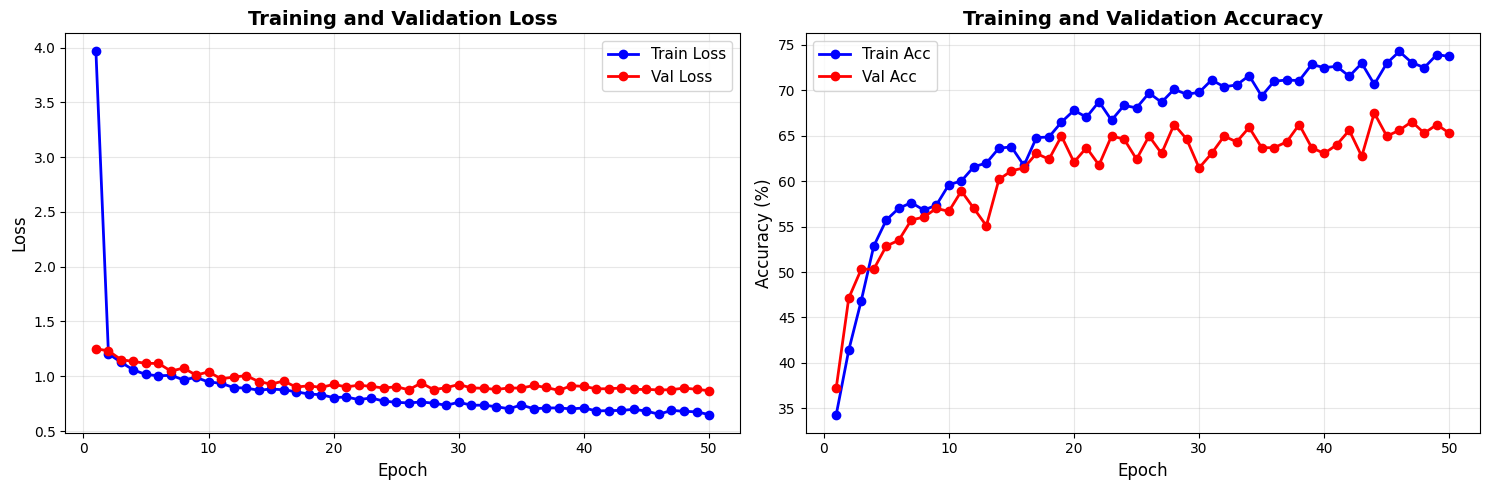

💾 Training curves saved to: c:\Users\Administrator\Desktop\Dan\Projects\waste-classifier-fastai\final_project\results\plots\05_simple_cnn_training_curves.png


In [11]:
# יצירת גרפים
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs_range, history['train_acc'], 'b-o', label='Train Acc', linewidth=2)
axes[1].plot(epochs_range, history['val_acc'], 'r-o', label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.PLOTS_DIR / '05_simple_cnn_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Training curves saved to:", config.PLOTS_DIR / '05_simple_cnn_training_curves.png')

## 9️⃣ ניתוח תוצאות 🔍

### 📊 מה אנחנו מחפשים?

In [12]:
# סיכום תוצאות
final_train_loss = history['train_loss'][-1]
final_train_acc = history['train_acc'][-1]
final_val_loss = history['val_loss'][-1]
final_val_acc = history['val_acc'][-1]

print("="*60)
print("📊 Final Results Summary")
print("="*60)
print(f"\n🎯 Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"\n📈 Final Epoch Results:")
print(f"   Train Loss: {final_train_loss:.4f}  |  Train Acc: {final_train_acc:.2f}%")
print(f"   Val Loss:   {final_val_loss:.4f}  |  Val Acc:   {final_val_acc:.2f}%")

# בדיקת overfitting
acc_gap = final_train_acc - final_val_acc
print(f"\n🔍 Analysis:")
print(f"   Accuracy Gap (Train-Val): {acc_gap:.2f}%")

if acc_gap < 5:
    print("   ✅ Good generalization! No significant overfitting.")
elif acc_gap < 15:
    print("   ⚠️  Some overfitting detected. Consider more regularization.")
else:
    print("   ❌ Significant overfitting! Need more data or stronger regularization.")

if final_val_acc < 50:
    print("   ⚠️  Low accuracy. Model might be underfitting.")
elif final_val_acc < 70:
    print("   📊 Moderate accuracy. Room for improvement.")
elif final_val_acc < 85:
    print("   👍 Good accuracy! Model is learning well.")
else:
    print("   🏆 Excellent accuracy! Model performs very well.")

print("="*60)

📊 Final Results Summary

🎯 Best Validation Accuracy: 67.52%

📈 Final Epoch Results:
   Train Loss: 0.6502  |  Train Acc: 73.74%
   Val Loss:   0.8681  |  Val Acc:   65.29%

🔍 Analysis:
   Accuracy Gap (Train-Val): 8.45%
   ⚠️  Some overfitting detected. Consider more regularization.
   📊 Moderate accuracy. Room for improvement.


## 🔟 שמירת היסטוריה ל-JSON

נשמור את כל התוצאות כדי שנוכל להשוות עם מודלים אחרים:

In [13]:
# שמירת היסטוריה
import json

results = {
    'model_name': 'SimpleCNN',
    'num_epochs': config.NUM_EPOCHS,
    'batch_size': config.BATCH_SIZE,
    'learning_rate': config.LEARNING_RATE,
    'optimizer': 'Adam',
    'best_val_acc': float(best_val_acc),
    'final_train_acc': float(final_train_acc),
    'final_val_acc': float(final_val_acc),
    'total_params': total_params,
    'training_time_minutes': total_time / 60,
    'history': history
}

results_path = config.LOGS_DIR / 'simple_cnn_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"💾 Results saved to: {results_path}")

💾 Results saved to: c:\Users\Administrator\Desktop\Dan\Projects\waste-classifier-fastai\final_project\results\logs\simple_cnn_results.json


## 📝 סיכום - מה עשינו במחברת הזו?

### ✅ השגים:
1. **בנינו SimpleCNN** - רשת עם 2 שכבות conv, 2 שכבות FC
2. **אימנו את המודל** - למשך 50 epochs על ~1,466 תמונות
3. **הערכנו ביצועים** - על validation set של ~314 תמונות
4. **שמרנו את המודל הטוב ביותר** - בקובץ `.pth`
5. **יצרנו ויזואליזציות** - גרפים של loss ו-accuracy
6. **תיעדנו הכל** - קובץ JSON עם כל התוצאות

### 🎓 מה למדנו?
- איך PyTorch מאמן רשתות (forward → loss → backward → update)
- ההבדל בין train ל-validation
- איך לזהות overfitting/underfitting
- איך לשמור ולטעון מודלים

### 🚀 הצעד הבא:
במחברת הבאה נוסיף **Batch Normalization** ו-**Regularization** חזקים יותר!

---

### 💡 שאלות הבנה:
1. למה train accuracy תמיד יותר גבוה מ-val accuracy?
2. מה ההבדל בין loss ל-accuracy?
3. למה Dropout פעיל רק ב-training ולא ב-validation?
4. מתי נדע שהמודל מתחיל לעשות overfitting?

<details>
  <summary>💡 תשובות</summary>
  
  1. **Train > Val:** המודל "רואה" את train set במהלך האימון ולומד אותו. Val set הוא חדש לגמרי.
  
  2. **Loss vs Accuracy:**
     - Loss: מדד רציף של "כמה המודל טועה" (יכול להיות כל מספר)
     - Accuracy: אחוז ניחושים נכונים (0-100%)
  
  3. **Dropout:** בvalidation רוצים לראות את הביצועים האמיתיים, לא לסמלץ "חסרון" ברשת.
  
  4. **Overfitting:** כש-train accuracy עולה אבל val accuracy יורד או עומד במקום.
</details>